In [1]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.2 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=eee72d78cca724b4d774cde686b11ad6c75b9302cf16b85509fa07d1606fee45
  Stored in directory: /tmp/pip-ephem-wheel-cache-z6jb_zox/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [4]:
!pip install -q transformers  rouge-score sentence-transformers

     |████████████████████████████████| 2.6 MB 5.1 MB/s 
     |████████████████████████████████| 85 kB 3.4 MB/s 
     |████████████████████████████████| 636 kB 45.4 MB/s 
     |████████████████████████████████| 895 kB 60.1 MB/s 
     |████████████████████████████████| 3.3 MB 38.3 MB/s 
     |████████████████████████████████| 1.2 MB 45.7 MB/s 


In [1]:
import tensorflow_datasets as tfds 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
from tqdm.notebook import tqdm

import tensorflow_hub as hub
from tensorflow import keras 
import tensorflow as tf
from IPython.display import Image 
import matplotlib.pyplot as plt

import os 

os.makedirs("data", exist_ok=True)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


In [3]:
nlp = spacy.load('en_core_web_lg')

In [9]:
class Net(nn.Module):
    def __init__(self, in_features=384):
        super(Net, self).__init__() 
        # classification head that accepts text features 
        self.cls_head = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features*3, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Dropout(p=0.5),
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.Sigmoid(),
            nn.Dropout(p=0.5),

            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, doc_feats, sentence_feats):
        
        # Multiply (element-wise) the feature vectors of the two images together, 
        # to generate a combined feature vector representing the similarity between the two.
        combined_features = doc_feats * sentence_feats  

        # get concat of both features and elementwise product
        x = torch.cat((doc_feats, sentence_feats, combined_features), dim=1)  
        output = self.cls_head(x)

        # print(output.shape)
        return output


In [89]:
#model path .. modify to location of trained model file 
model_path = "drive/MyDrive/mlexperiments/extractivesummarization/models/bal_exsum_dict.pth"

In [90]:
model = Net() 
model.load_state_dict(torch.load(sum_dir + "models/bal_exsum_dict.pth", map_location=torch.device('cpu') ))
model.eval();
# model = torch.load(sum_dir + "models/bal_exsum.pt")

## Extractive Summarization Inference 



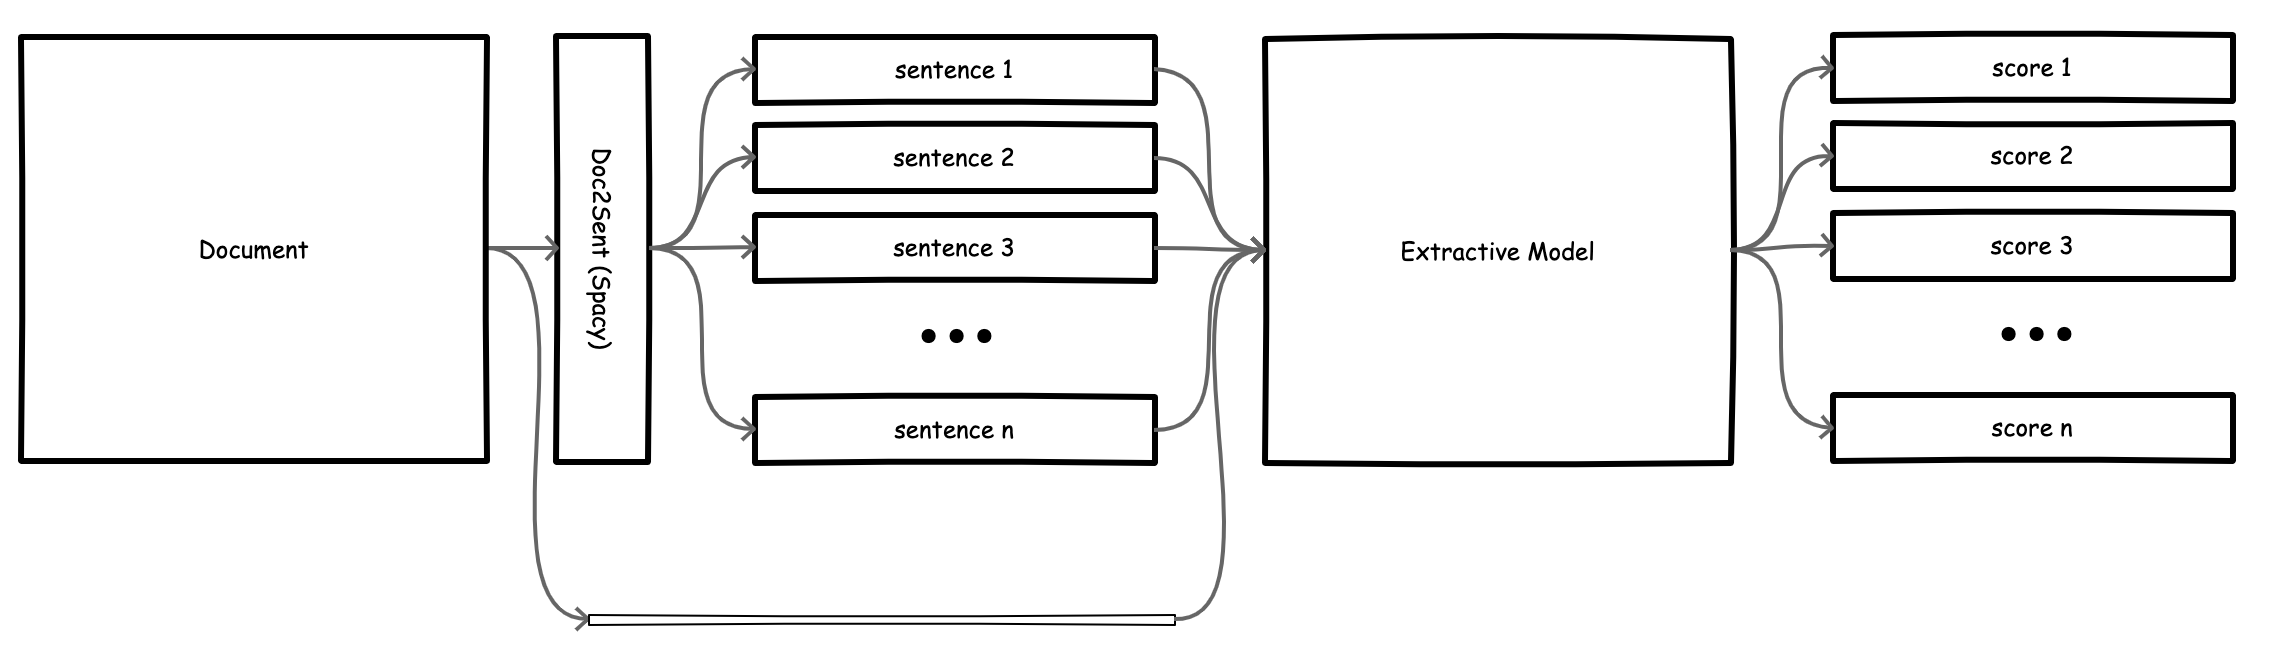

In [91]:
from transformers import AutoTokenizer, AutoModel
import torch

#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/paraphrase-MiniLM-L6-v2")
sentence_model = AutoModel.from_pretrained("sentence-transformers/paraphrase-MiniLM-L6-v2")



#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


def get_sentence_embedding(sentences):
    encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=512, return_tensors='pt')
    with torch.no_grad():
      model_output = sentence_model(**encoded_input)
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    return sentence_embeddings

#Sentences we want sentence embeddings for
sentences = ['This framework generates embeddings for each input sentence',
             'Sentences are passed as a list of string.',
             'Twitter is rolling out changes to its newly rebuilt API that will allow third-party developers to build tools and other solutions specifically for its audio chatroom product, Twitter Spaces. The company today announced it’s shipping new endpoints to support Spaces on the Twitter API v2, with the initial focus on enabling discovery of live or scheduled Spaces. This may later be followed by an API update that will make it possible for developers to build out more tools for Spaces’ hosts.With the current API update, Twitter hopes developers will build new products that enable users — both on and off Twitter — to find Twitter Spaces more easily, the company says. This could potentially broaden the reach of Spaces and introduce its audio chats to more people, which could give Twitter a leg up in the increasingly competitive landscape for audio-based social networking. Today, Twitter Spaces isn’t only taking on Clubhouse, but also the audio chat experiences being offered by Facebook, Discord, Reddit, Public.com, Spotify and smaller social apps.']




In [96]:
def summarize(doc, model, min_sentence_length=14, top_k=4):
  doc_sentences = []
  for sent in nlp(doc).sents:
    if len(sent) > min_sentence_length: 
      doc_sentences.append(str(sent))
  
  sent_embs = get_sentence_embedding(doc_sentences)
  doc_tensor = get_sentence_embedding([article]) 
  doc_embs = doc_tensor.repeat(len(doc_sentences),1)


  # model_input =   {"sentence":  tf.convert_to_tensor(doc_sentences, dtype=tf.string) , "document": tf.convert_to_tensor([doc] * len(doc_sentences), dtype=tf.string) }
  scores = model(sent_embs, doc_embs)

  sent_pred_list = [{"sentence": doc_sentences[i], "score": scores[i][0], "index":i} for i in range(len(doc_sentences))]
  sorted_sentences = sorted(sent_pred_list, key=lambda k: k['score'], reverse=True) 

  sorted_result = sorted_sentences[:top_k] 
  sorted_result = sorted(sorted_result, key=lambda k: k['index']) 
  
  summary = [ x["sentence"] for x in sorted_result]
  summary = " ".join(summary)

  return summary


In [97]:
article = """ Birds are a group of warm-blooded vertebrates constituting the class Aves /ˈeɪviːz/, characterised by feathers, toothless beaked jaws, the laying of hard-shelled eggs, a high metabolic rate, a four-chambered heart, and a strong yet lightweight skeleton. Birds live worldwide and range in size from the 5.5 cm (2.2 in) bee hummingbird to the 2.8 m (9 ft 2 in) ostrich. There are about ten thousand living species, more than half of which are passerine, or “perching” birds. Birds have wings whose development varies according to species; the only known groups without wings are the extinct moa and elephant birds. Wings, which evolved from forelimbs, gave birds the ability to fly, although further evolution has led to the loss of flight in some birds, including ratites, penguins, and diverse endemic island species. The digestive and respiratory systems of birds are also uniquely adapted for flight. Some bird species of aquatic environments, particularly seabirds and some waterbirds, have further evolved for swimming. Birds are feathered theropod dinosaurs and constitute the only known living dinosaurs. Likewise, birds are considered reptiles in the modern cladistic sense of the term, and their closest living relatives are the crocodilians. Birds are descendants of the primitive avialans (whose members include Archaeopteryx) which first appeared about 160 million years ago (mya) in China. According to DNA evidence, modern birds (Neornithes) evolved in the Middle to Late Cretaceous, and diversified dramatically around the time of the Cretaceous–Paleogene extinction event 66 mya, which killed off the pterosaurs and all known non-avian dinosaurs. Many social species pass on knowledge across generations, which is considered a form of culture. Birds are social, communicating with visual signals, calls, and songs, and participating in such behaviours as cooperative breeding and hunting, flocking, and mobbing of predators. The vast majority of bird species are socially (but not necessarily sexually) monogamous, usually for one breeding season at a time, sometimes for years, but rarely for life. Other species have breeding systems that are polygynous (one male with many females) or, rarely, polyandrous (one female with many males). Birds produce offspring by laying eggs which are fertilised through sexual reproduction. They are usually laid in a nest and incubated by the parents. Most birds have an extended period of parental care after hatching. Many species of birds are economically important as food for human consumption and raw material in manufacturing, with domesticated and undomesticated birds being important sources of eggs, meat, and feathers. Songbirds, parrots, and other species are popular as pets. Guano (bird excrement) is harvested for use as a fertiliser. Birds figure throughout human culture. About 120 to 130 species have become extinct due to human activity since the 17th century, and hundreds more before then. Human activity threatens about 1,200 bird species with extinction, though efforts are underway to protect them. Recreational birdwatching is an important part of the ecotourism industry. """

In [98]:
article

' Birds are a group of warm-blooded vertebrates constituting the class Aves /ˈeɪviːz/, characterised by feathers, toothless beaked jaws, the laying of hard-shelled eggs, a high metabolic rate, a four-chambered heart, and a strong yet lightweight skeleton. Birds live worldwide and range in size from the 5.5 cm (2.2 in) bee hummingbird to the 2.8 m (9 ft 2 in) ostrich. There are about ten thousand living species, more than half of which are passerine, or “perching” birds. Birds have wings whose development varies according to species; the only known groups without wings are the extinct moa and elephant birds. Wings, which evolved from forelimbs, gave birds the ability to fly, although further evolution has led to the loss of flight in some birds, including ratites, penguins, and diverse endemic island species. The digestive and respiratory systems of birds are also uniquely adapted for flight. Some bird species of aquatic environments, particularly seabirds and some waterbirds, have furt

In [99]:
summarize(article, model, min_sentence_length=14, top_k=4)

' Birds are a group of warm-blooded vertebrates constituting the class Aves /ˈeɪviːz/, characterised by feathers, toothless beaked jaws, the laying of hard-shelled eggs, a high metabolic rate, a four-chambered heart, and a strong yet lightweight skeleton. Birds are descendants of the primitive avialans (whose members include Archaeopteryx) which first appeared about 160 million years ago (mya) in China. 66 mya, which killed off the pterosaurs and all known non-avian dinosaurs. Many social species pass on knowledge across generations, which is considered a form of culture.'